In [186]:
import pandas as pd
import numpy as np
import yfinance as yf 
import  matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.preprocessing import StandardScaler,  MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Скачаем финансовые данные

In [3]:
assets_list = ["BTC", 
"ETH",
"USDT",
"USDC",
"BNB",
"XRP",
"BUSD",
"ADA",
"SOL",
"DOGE",
"DOT",
"DAI",
"MATIC",
"WTRX",
"SHIB",
"HEX",
"TRX",
"AVAX",
"UNI1",
"WBTC",
"STETH",
"LEO",
"YOUC",
"LTC",
"LINK",
"ETC",
"ATOM",
"FTT",
"XLM",
"NEAR",
"CRO",
"XMR",
"ALGO",
"BCH",
"BTCB",
"LUNA1",
"FLOW",
"QNT",
"VET",
"APE3",
"TONCOIN",
"FIL",
"ICP",
"XCN1",
"CHZ",
"FRAX",
"HBAR",
"XTZ",
"MANA",
"SAND",
"WBNB",
"EOS",
"EGLD",
"THETA",
"AAVE",
"AXS",
"BIT1",
"OKB",
"USDP",
"BSV",
"KCS",
"TUSD",
"ZEC",
"MIOTA",
"BTT",
"XEC",
"HBTC",
"MKR",
"USDD",
"BTT2",
"HT",
"CAKE",
"HNT",
"GRT1",
"USDN",
"NEO",
"KLAY",
"FTM",
"SNX",
"PAXG",
"NEXO",
"RUNE",
"LDO",
"CRV",
"GT",
"DASH",
"ENJ",
"BAT",
"MV",
"COMP1",
"STX",
"KAVA",
"FEI",
"WAVES",
"ZIL",
"RVN",
"XAUT",
"MINA",
"LRC",
"XDC"
]
crypto_assets = list(pd.Series(assets_list).astype(str)+'-USD')

In [4]:
crypto_list_df = pd.DataFrame(columns=crypto_assets)
crypto_list_df = yf.download(crypto_assets, start = '2021-10-01', end = '2022-10-01')['Close']
crypto_list_df.reset_index(inplace=True)
df_new = crypto_list_df.T
df_new.drop(df_new.index[[0, 1]], inplace = True)

[*********************100%***********************]  100 of 100 completed


## Обработаем данные

In [5]:
df_new.dropna(how='any', inplace = True)

In [6]:
df_new['ticker'] = df_new.index

## Масштабируем данные

In [7]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_new.iloc[:,:-1].T).T

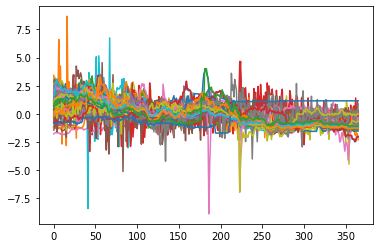

In [8]:
plt.plot(data_scaled.T)
plt.show()

In [9]:
data_scaled_df = pd.DataFrame(data_scaled, index=df_new.index, columns=df_new.iloc[:,:-1].columns)

# Получим фичи

In [10]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from sklearn.feature_selection import VarianceThreshold

Выделим минимальный набор признаков

In [11]:
settings_minimal = settings.MinimalFCParameters()
settings_minimal

{'sum_values': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None, 'maximum': None, 'absolute_maximum': None, 'minimum': None}

Выделим time-based признаки

In [12]:
settings_time = settings.TimeBasedFCParameters()
settings_time.update(settings_minimal)
settings_time

{'linear_trend_timewise': [{'attr': 'pvalue'}, {'attr': 'rvalue'}, {'attr': 'intercept'}, {'attr': 'slope'}, {'attr': 'stderr'}], 'sum_values': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None, 'maximum': None, 'absolute_maximum': None, 'minimum': None}

Выделим более широкий набор признаков

In [13]:
settings_efficient = settings.EfficientFCParameters()

Выделим наиболее широкий набор признаков, но затратный в вычислительном плане

In [14]:
settings_comprehensive = settings.ComprehensiveFCParameters()

## Преобразуем data-set в long формат

In [15]:
data_long = pd.DataFrame({
    0: data_scaled_df.values.flatten(),
    1: np.arange(data_scaled_df.shape[0]).repeat(data_scaled_df.shape[1])
})
data_long.head()

0  1
0  1.983817  0
1  2.242624  0
2  2.230612  0
3  2.233160  0
4  2.118527  0

Извлечём признаки с помощью extract_features

In [16]:
X_efficient = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings_efficient)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


In [17]:
X_comprehensive = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings_comprehensive)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.08s/it]


In [18]:
X_time = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings_time)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.07it/s]


# K-means кластеризация:

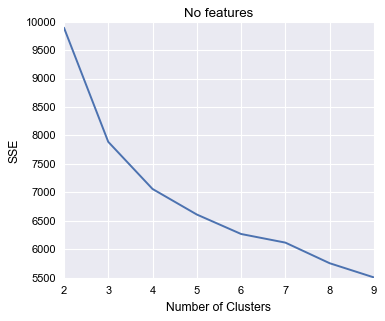

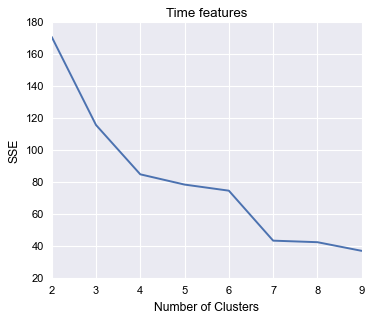

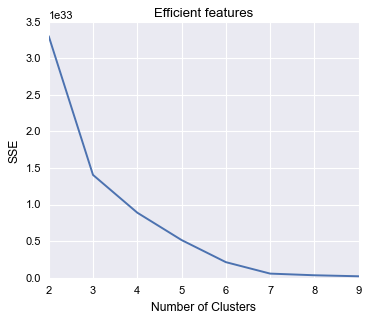

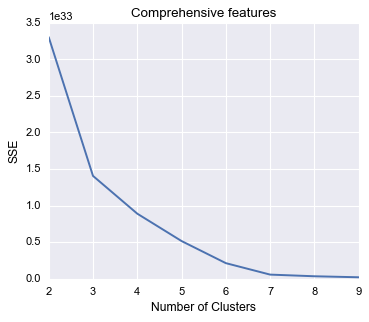

In [289]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

for feature_matrix, name in zip([data_scaled_df, X_time, X_efficient, X_comprehensive], ['No features', 'Time features', 'Efficient features', 'Comprehensive features']):
    sse = []
    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(feature_matrix)
        sse.append(kmeans.inertia_)

    plt.figure(figsize=(5,4))
    for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
        plt.rcParams[param] = '0'
    plt.title(name)
    plt.plot(range(2, 10), sse)
    plt.xticks(range(2, 10))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()

Сравним K-means без feature extractor'а и k-means с comprehensive features

In [228]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(data_scaled_df)

KMeans(init='random', n_clusters=4, random_state=42)

In [229]:
KMeans(init='random', n_clusters=4, random_state=42)
kmeans_w_features = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans_w_features.fit(X_comprehensive)

KMeans(init='random', n_clusters=4, random_state=42)

In [278]:
KMeans(init='random', n_clusters=4, random_state=42)
kmeans_eff_features = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans_eff_features.fit(X_efficient)

KMeans(init='random', n_clusters=4, random_state=42)

In [279]:
KMeans(init='random', n_clusters=4, random_state=42)
kmeans_time_features = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans_time_features.fit(X_time)

KMeans(init='random', n_clusters=4, random_state=42)

Кластеры без feature extractor:

In [105]:
for i in range(0,4):
    print(f'==== Кластер ===== {i} ====')
    print(data_scaled_df.index[kmeans.labels_ == i])

==== Кластер ===== 0 ====
Index(['ADA-USD', 'ALGO-USD', 'ATOM-USD', 'AXS-USD', 'BCH-USD', 'BIT1-USD',
       'BSV-USD', 'BTC-USD', 'BTCB-USD', 'BTT-USD', 'CAKE-USD', 'CHZ-USD',
       'COMP1-USD', 'DASH-USD', 'DOGE-USD', 'DOT-USD', 'EGLD-USD', 'EOS-USD',
       'ETC-USD', 'ETH-USD', 'FEI-USD', 'FIL-USD', 'FLOW-USD', 'FTM-USD',
       'FTT-USD', 'GRT1-USD', 'HBAR-USD', 'HBTC-USD', 'HEX-USD', 'ICP-USD',
       'KAVA-USD', 'KLAY-USD', 'LDO-USD', 'LINK-USD', 'LTC-USD', 'MINA-USD',
       'MIOTA-USD', 'MKR-USD', 'NEO-USD', 'QNT-USD', 'RUNE-USD', 'RVN-USD',
       'SHIB-USD', 'SNX-USD', 'SOL-USD', 'STETH-USD', 'THETA-USD', 'TRX-USD',
       'UNI1-USD', 'VET-USD', 'WAVES-USD', 'WBTC-USD', 'XDC-USD', 'XEC-USD',
       'XLM-USD', 'XMR-USD', 'XRP-USD', 'XTZ-USD', 'ZIL-USD'],
      dtype='object')
==== Кластер ===== 1 ====
Index(['AVAX-USD', 'BAT-USD', 'BNB-USD', 'CRO-USD', 'CRV-USD', 'ENJ-USD',
       'GT-USD', 'HNT-USD', 'HT-USD', 'KCS-USD', 'LRC-USD', 'LUNA1-USD',
       'MANA-USD', 'MATIC-USD

Кластеры c feature extractor:

In [106]:
for i in range(0,4):
    print(f'==== Кластер ===== {i} ====')
    print(data_scaled_df.index[kmeans_w_features.labels_ == i])

==== Кластер ===== 0 ====
Index(['AVAX-USD', 'BTCB-USD', 'BUSD-USD', 'COMP1-USD', 'CRV-USD', 'DAI-USD',
       'DOT-USD', 'EOS-USD', 'FEI-USD', 'FRAX-USD', 'GRT1-USD', 'HBTC-USD',
       'HEX-USD', 'HNT-USD', 'KLAY-USD', 'LDO-USD', 'LEO-USD', 'LINK-USD',
       'MINA-USD', 'MIOTA-USD', 'OKB-USD', 'PAXG-USD', 'QNT-USD', 'SHIB-USD',
       'SOL-USD', 'STETH-USD', 'STX-USD', 'TRX-USD', 'TUSD-USD', 'USDC-USD',
       'USDN-USD', 'USDP-USD', 'USDT-USD', 'WBNB-USD', 'XAUT-USD', 'XEC-USD'],
      dtype='object')
==== Кластер ===== 1 ====
Index(['CRO-USD', 'KAVA-USD', 'RUNE-USD'], dtype='object')
==== Кластер ===== 2 ====
Index(['ADA-USD', 'ALGO-USD', 'BAT-USD', 'BCH-USD', 'BIT1-USD', 'BTT-USD',
       'DASH-USD', 'EGLD-USD', 'ETC-USD', 'FLOW-USD', 'FTM-USD', 'FTT-USD',
       'GT-USD', 'HT-USD', 'ICP-USD', 'LRC-USD', 'NEO-USD', 'RVN-USD',
       'SNX-USD', 'UNI1-USD', 'VET-USD', 'WBTC-USD', 'XMR-USD', 'XRP-USD',
       'XTZ-USD', 'ZEC-USD'],
      dtype='object')
==== Кластер ===== 3 ====
Ind

In [290]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(int(np.ceil(current_cluster.shape[0]/4)), \
                           4, figsize = (15, 3*int(np.ceil(current_cluster.shape[0]/4))))
    fig.autofmt_xdate(rotation = 45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[:-3])
        ax[index].set_title(f'{row.ticker}\n')
        plt.xticks(rotation = 45)

    plt.tight_layout()
    plt.show()

=======================================================  Cluster 0  =================================================================================================


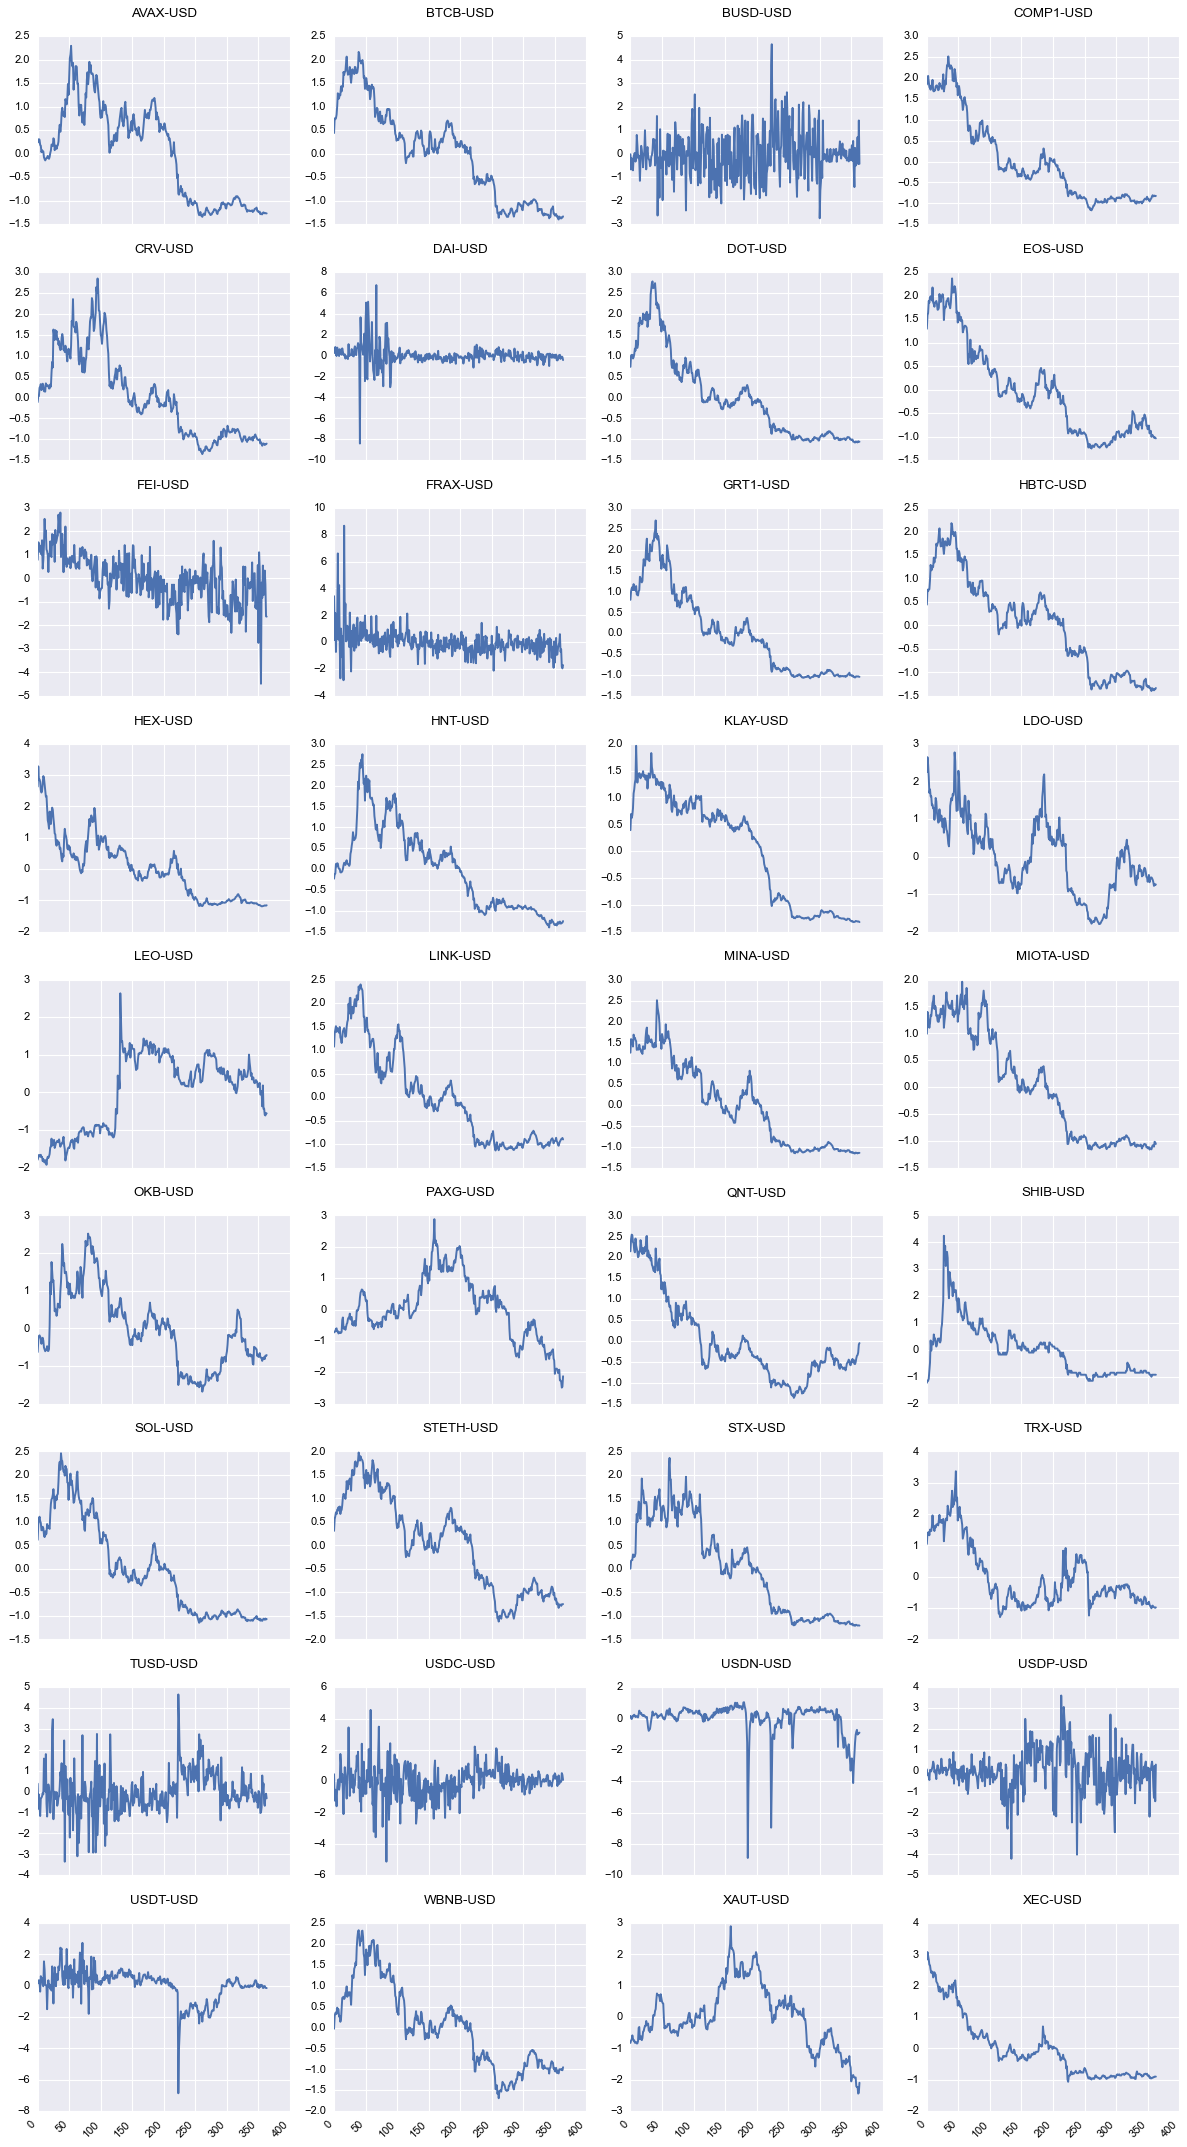

=======================================================  Cluster 1  =================================================================================================


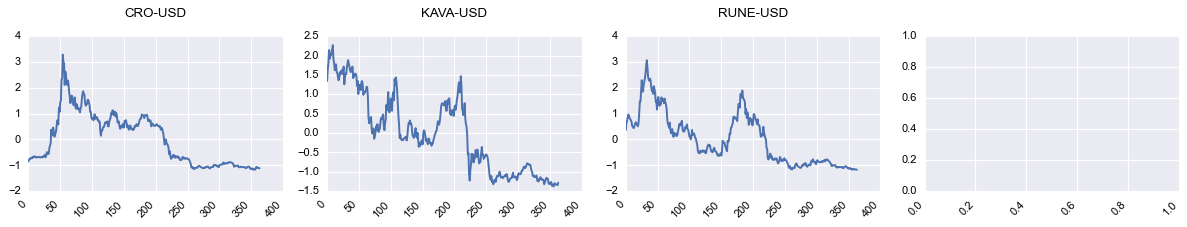

=======================================================  Cluster 2  =================================================================================================


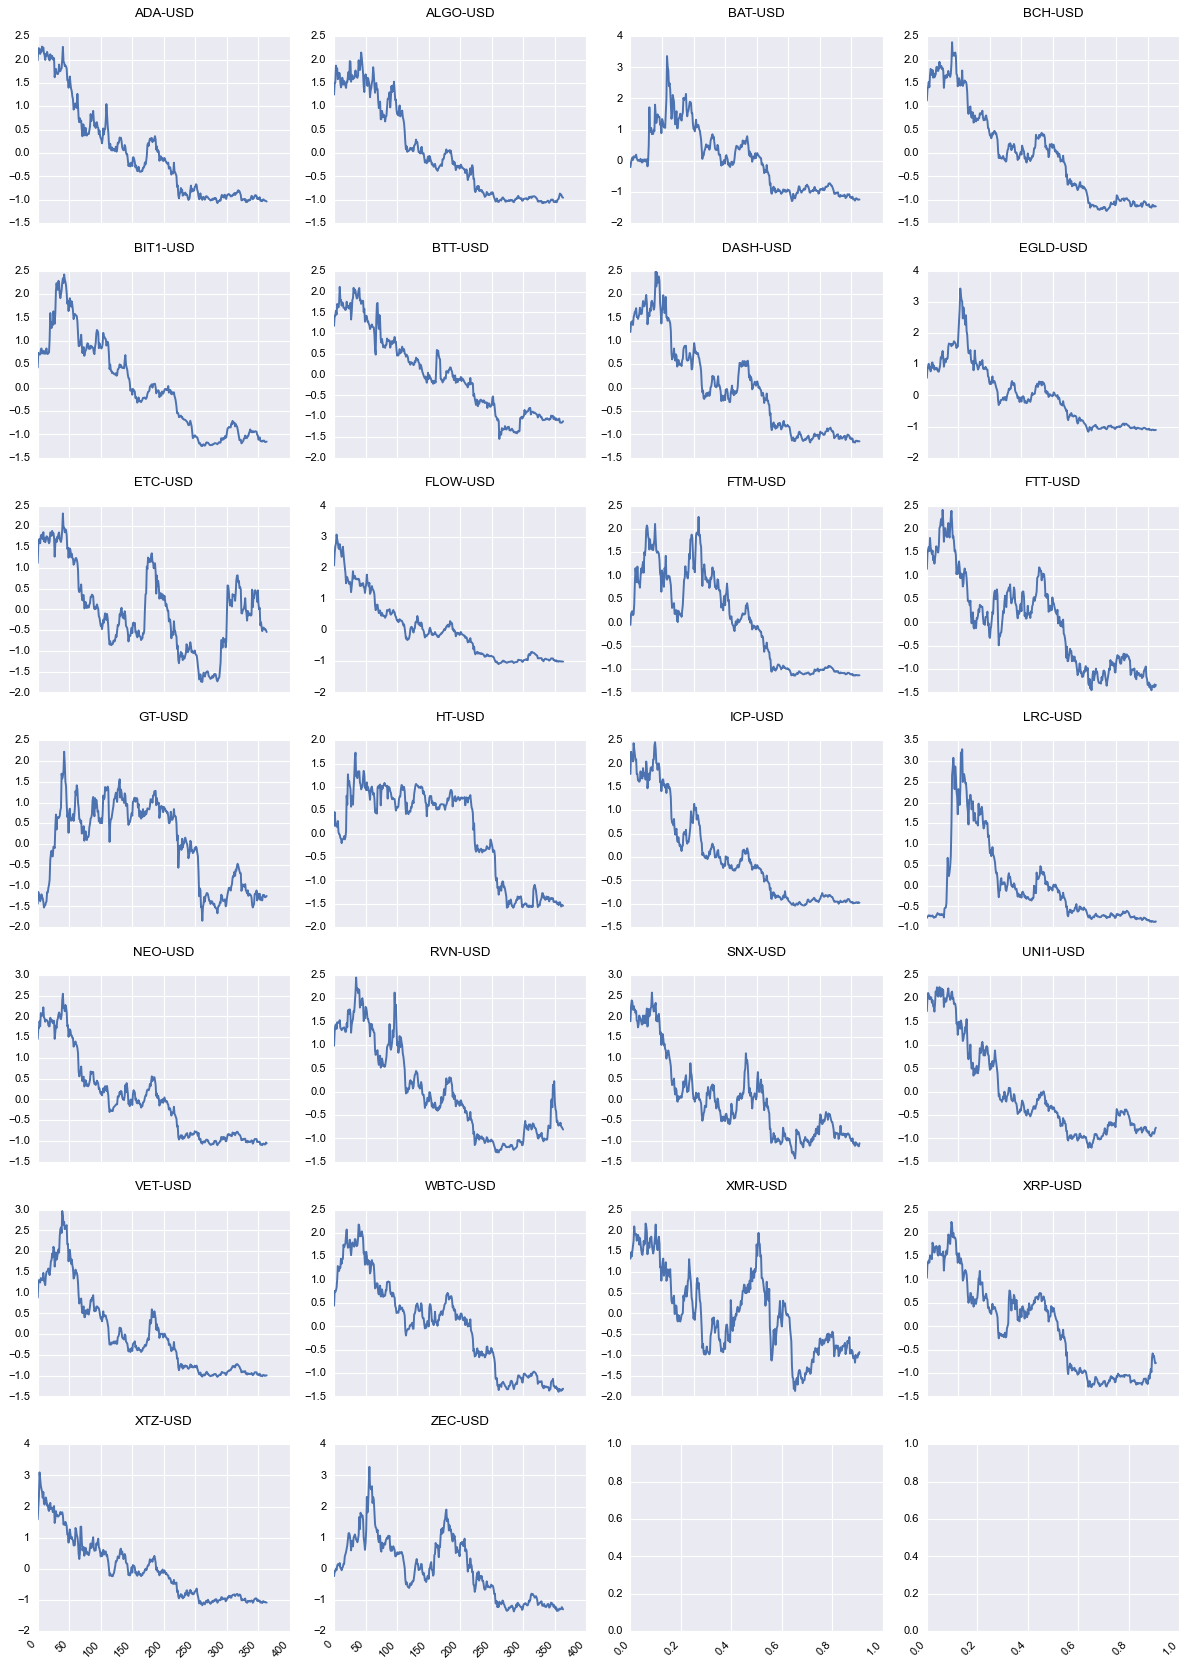

=======================================================  Cluster 3  =================================================================================================


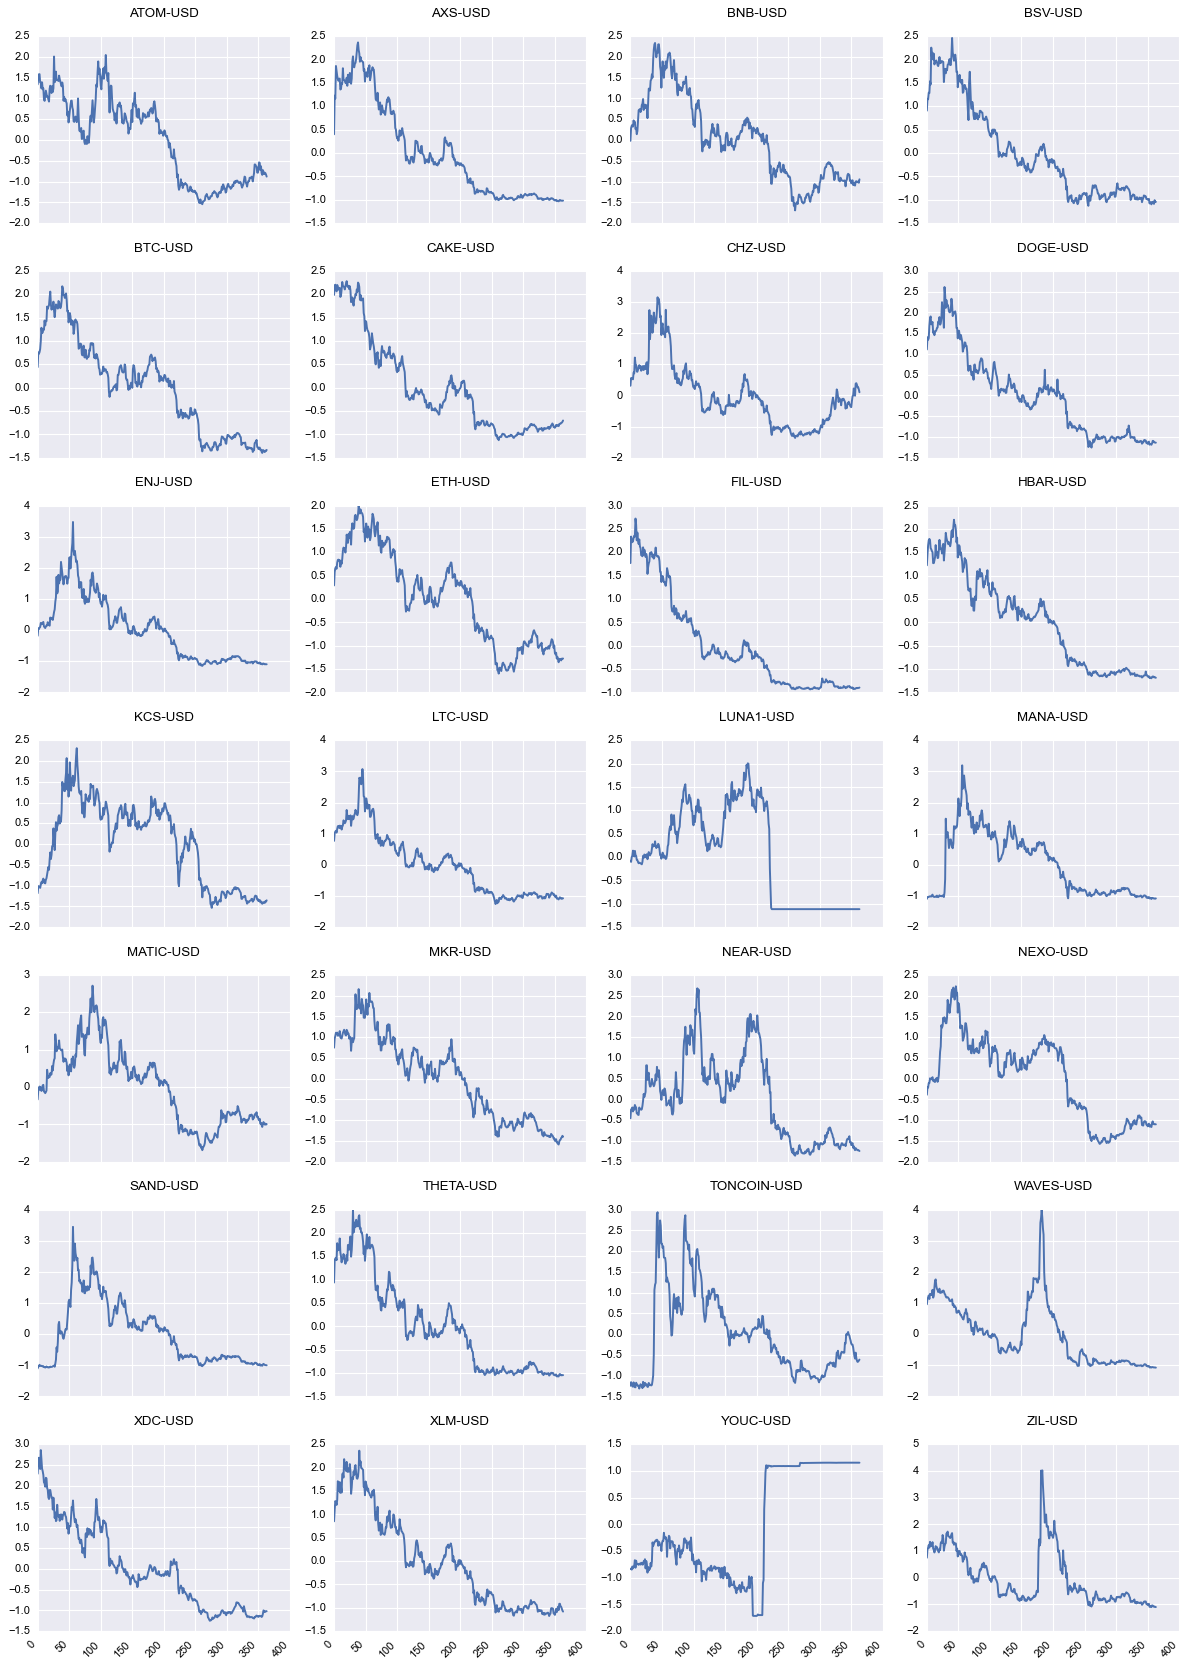

In [293]:
df_cluster = data_scaled_df.copy()
df_cluster['ticker']=df_cluster.index
for cluster in range(0, 4):
    print(f"=======================================================  Cluster {cluster}  =================================================================================================")
    plot_cluster_tickers(df_cluster.loc[df_cluster.index[kmeans_w_features.labels_ == cluster]])

=======================================================  Cluster 0  =================================================================================================


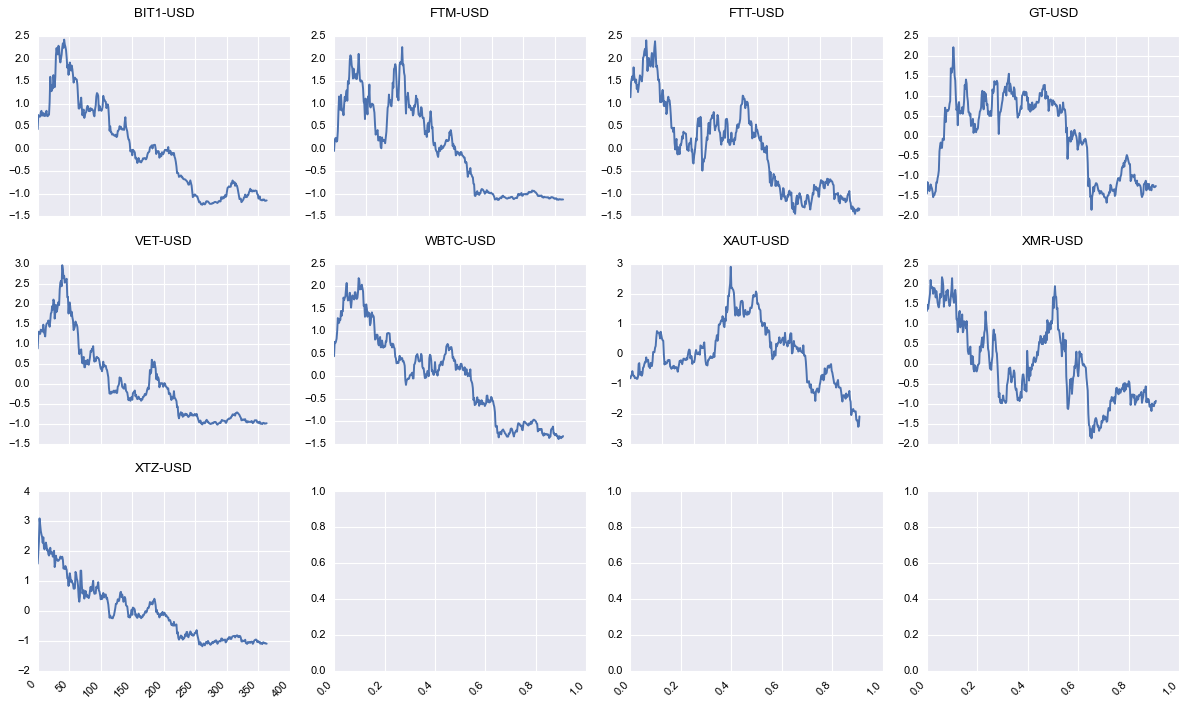

=======================================================  Cluster 1  =================================================================================================


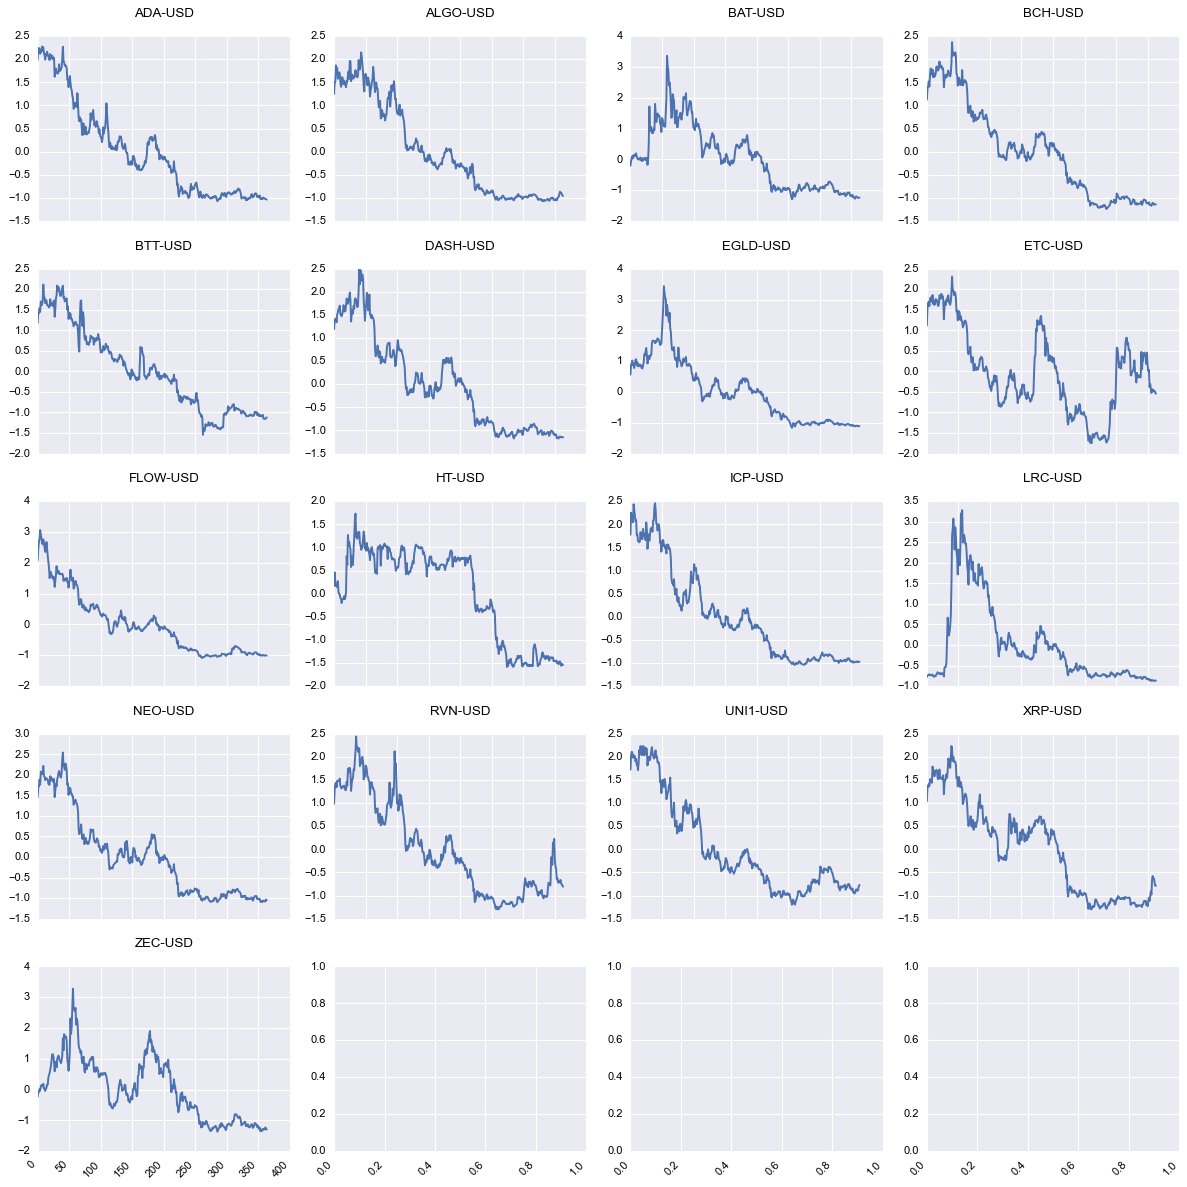

=======================================================  Cluster 2  =================================================================================================


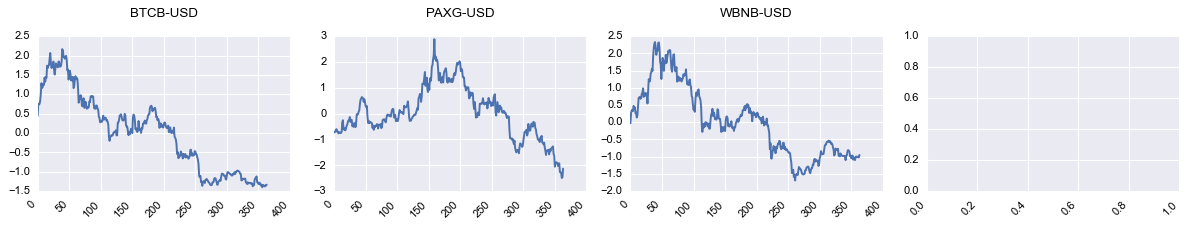

=======================================================  Cluster 3  =================================================================================================


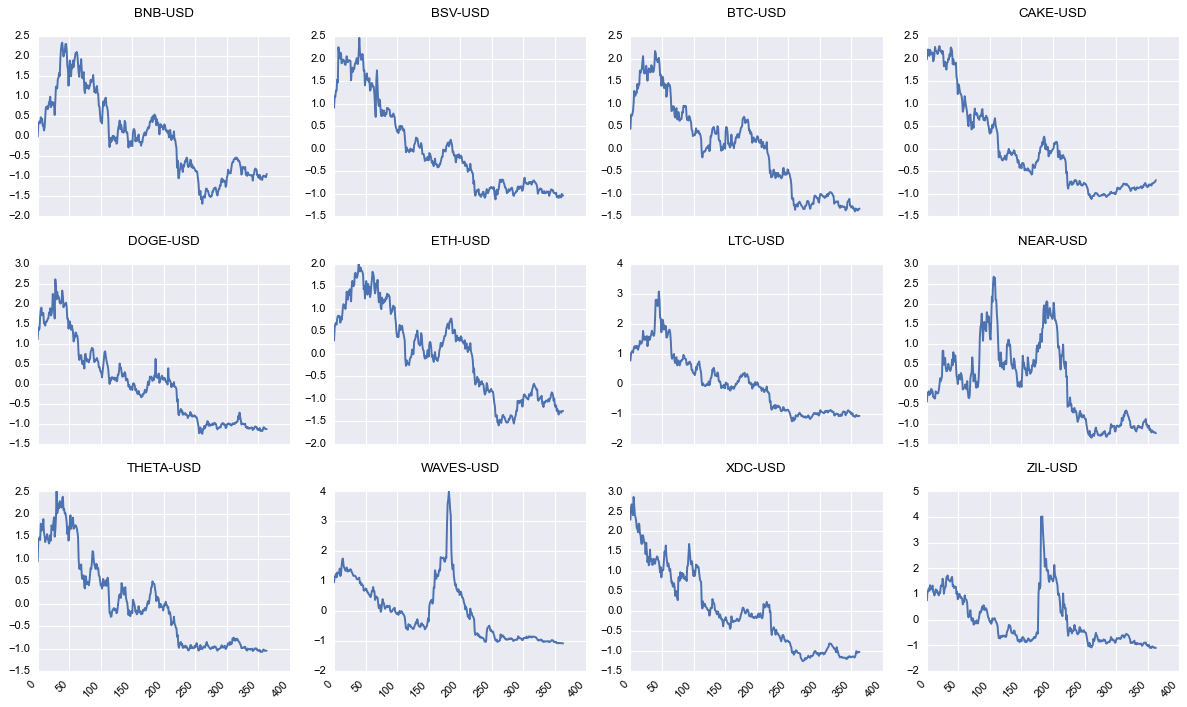

In [292]:
df_cluster = data_scaled_df.copy()
df_cluster['ticker']=df_cluster.index
for cluster in range(0, 4):
    print(f"=======================================================  Cluster {cluster}  =================================================================================================")
    plot_cluster_tickers(df_cluster.loc[df_cluster.index[kmeans.labels_ == cluster]])

=======================================================  Cluster 0  =================================================================================================


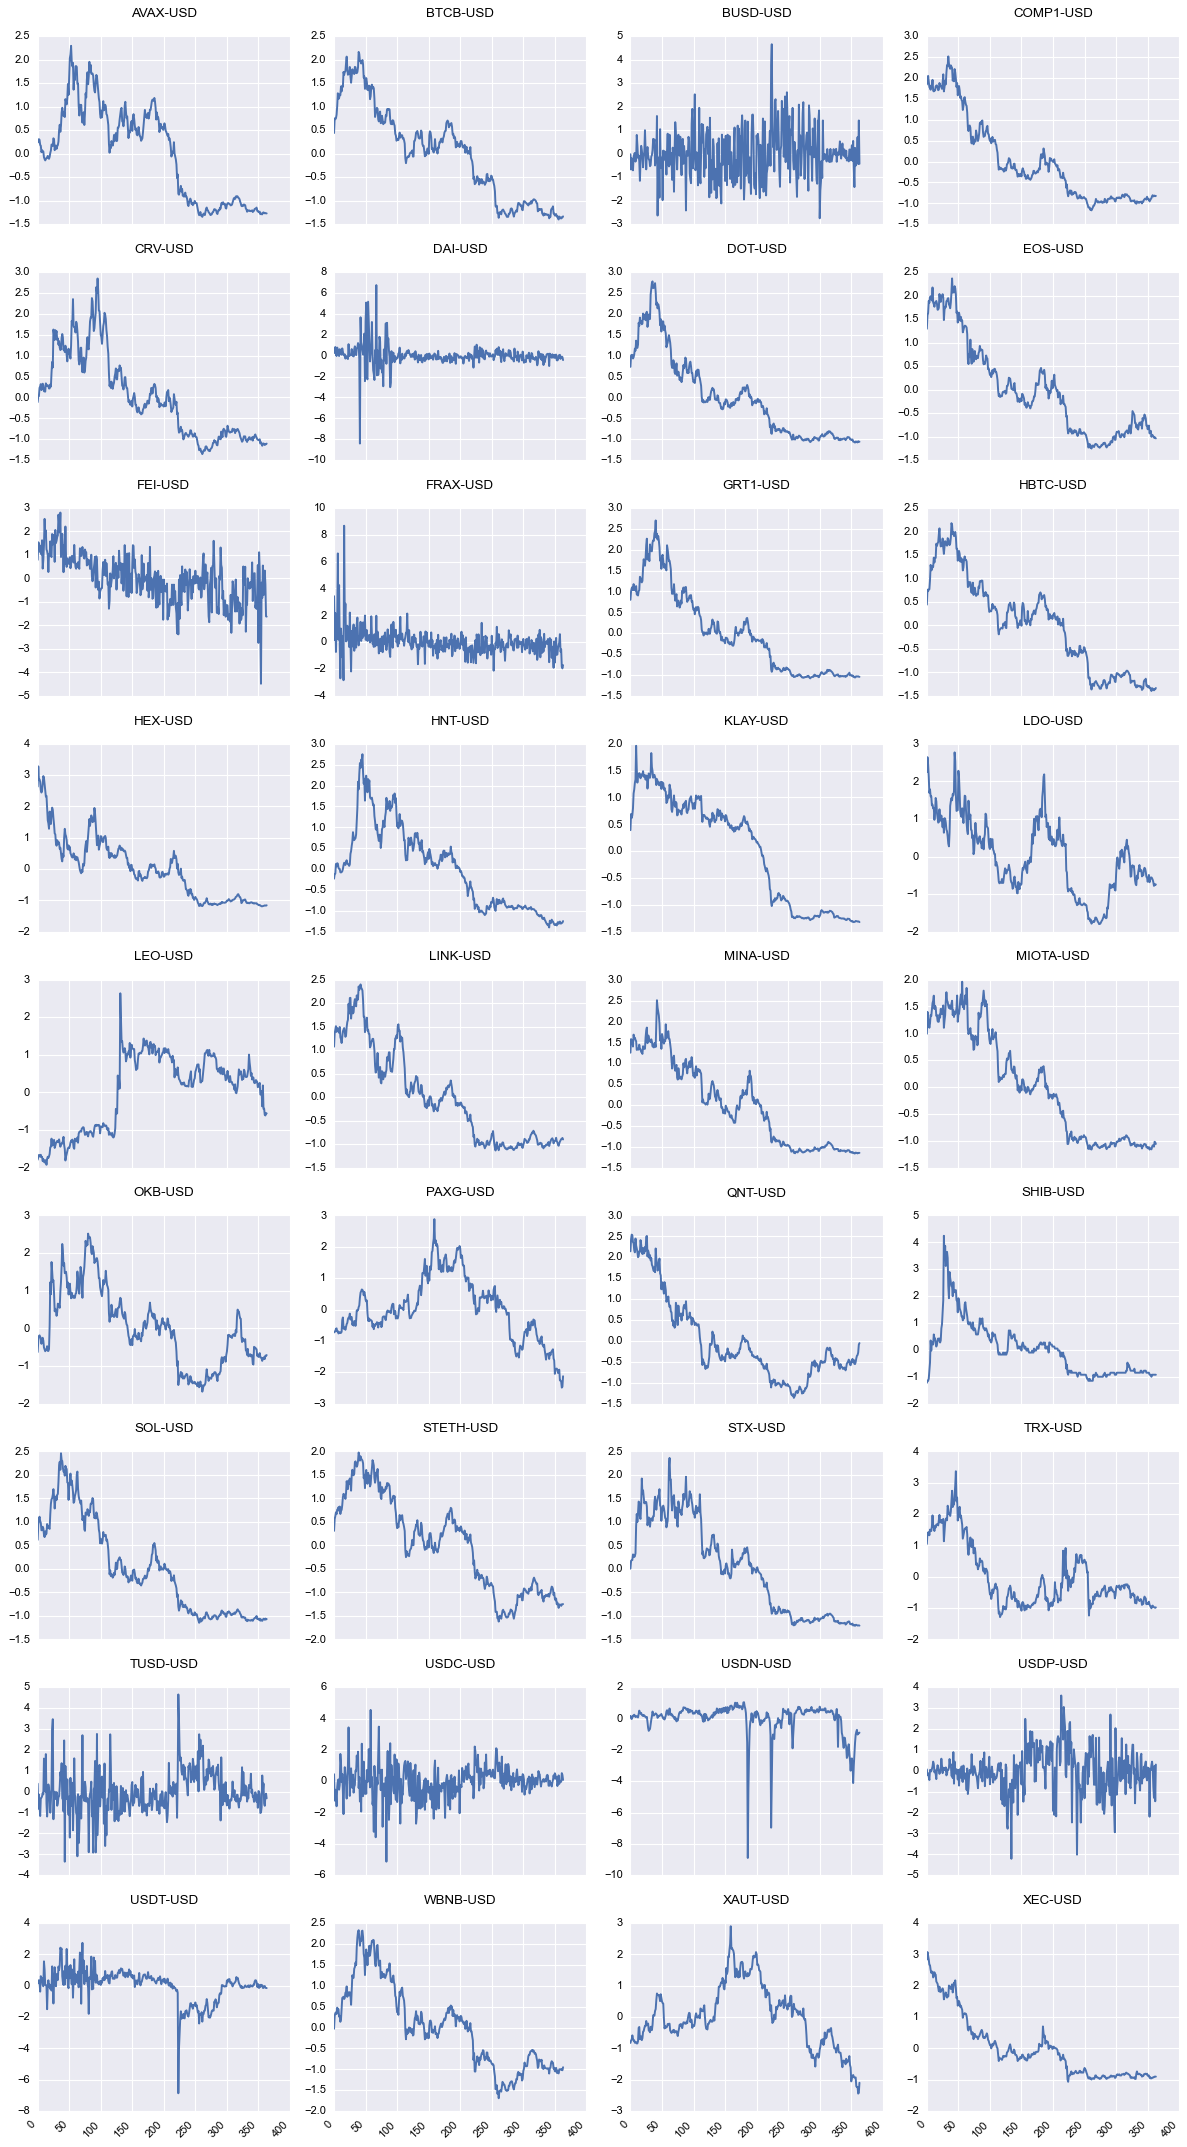

=======================================================  Cluster 1  =================================================================================================


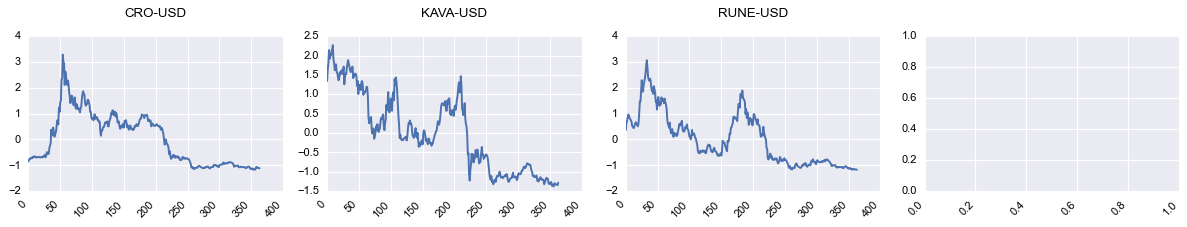

=======================================================  Cluster 2  =================================================================================================


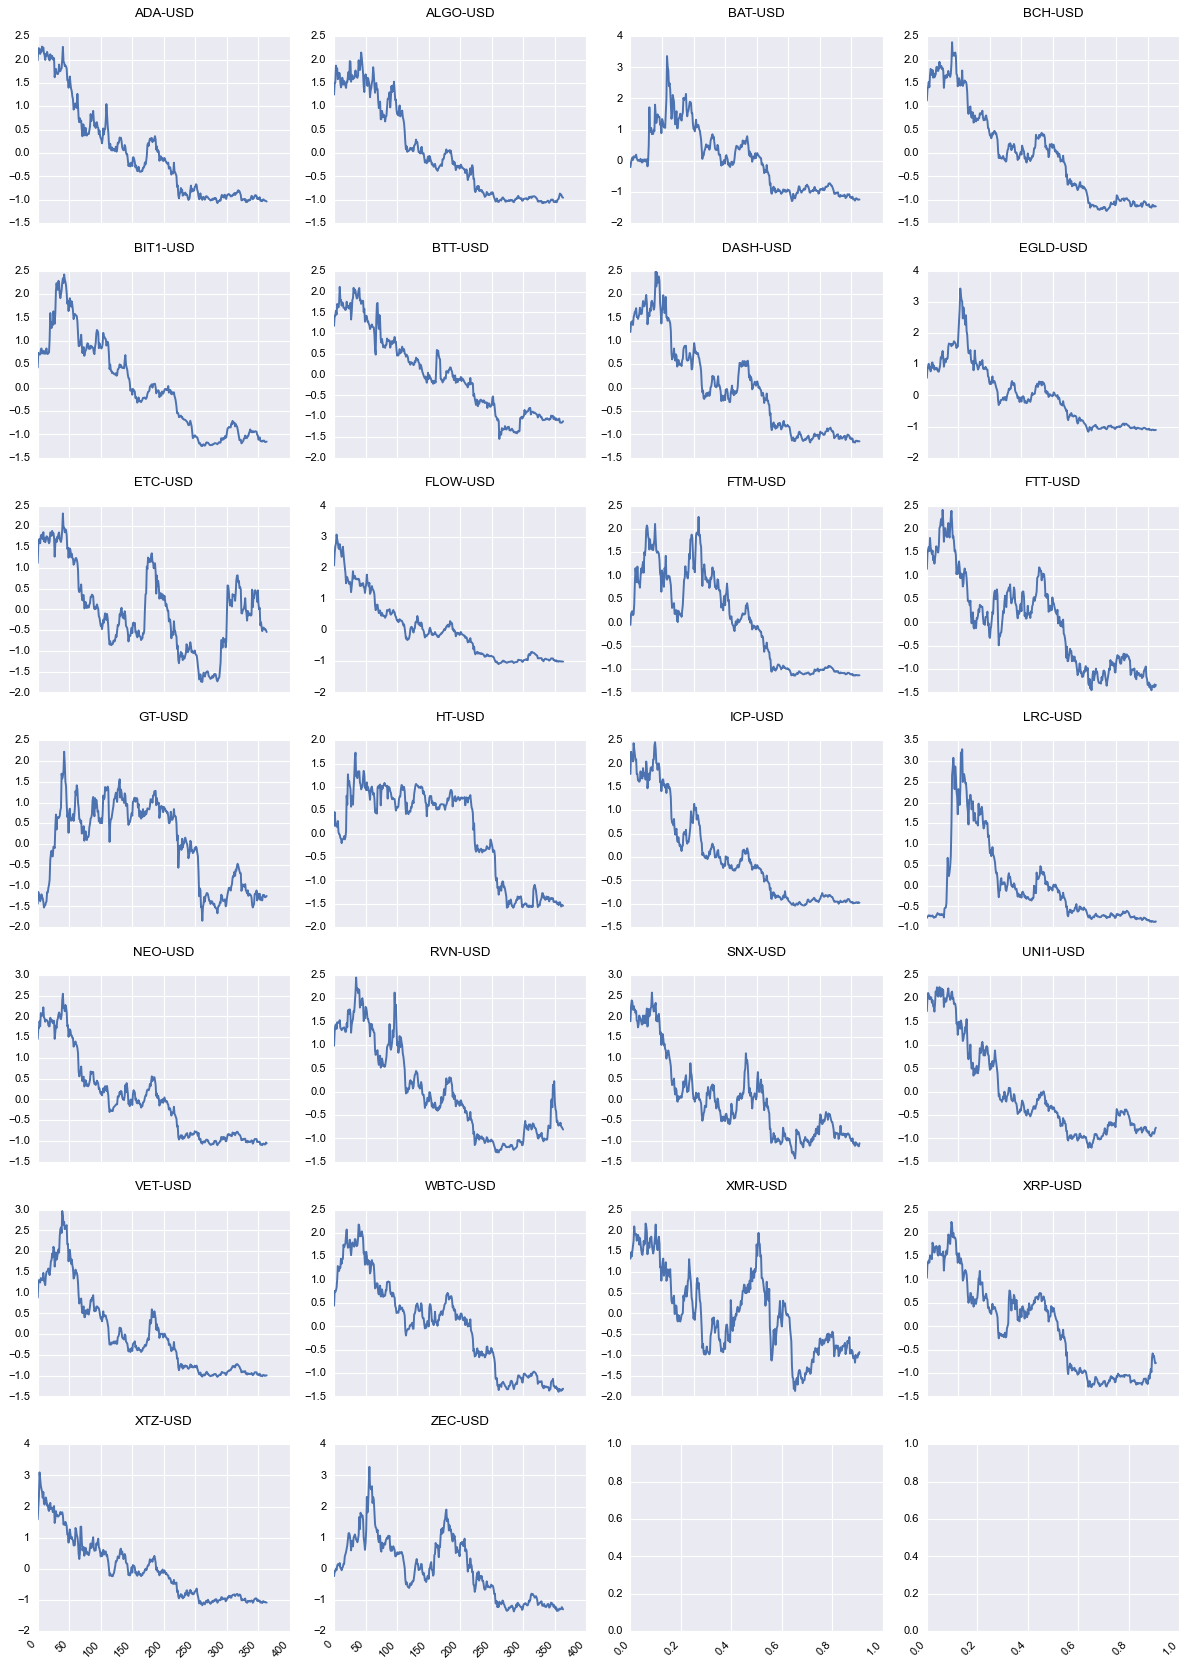

=======================================================  Cluster 3  =================================================================================================


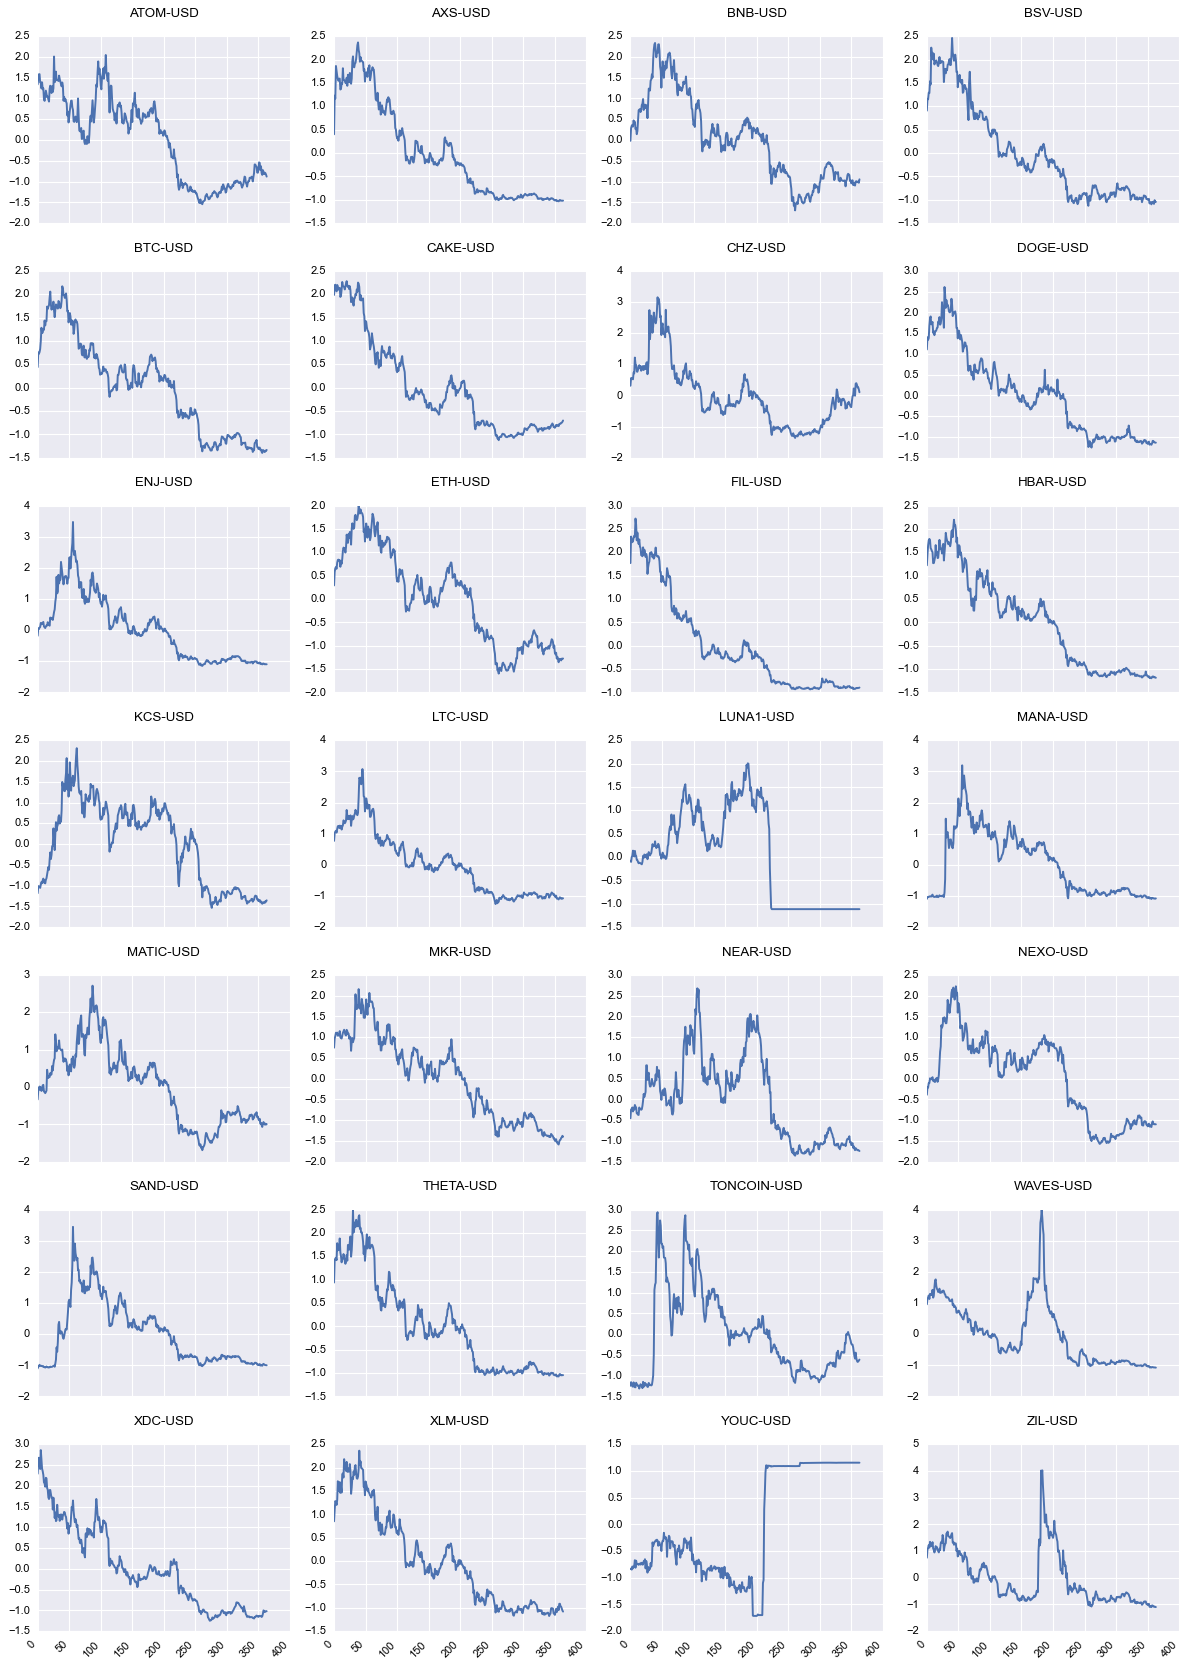

In [294]:
df_cluster = data_scaled_df.copy()
df_cluster['ticker']=df_cluster.index
for cluster in range(0, 4):
    print(f"=======================================================  Cluster {cluster}  =================================================================================================")
    plot_cluster_tickers(df_cluster.loc[df_cluster.index[kmeans_eff_features.labels_ == cluster]])

=======================================================  Cluster 0  =================================================================================================


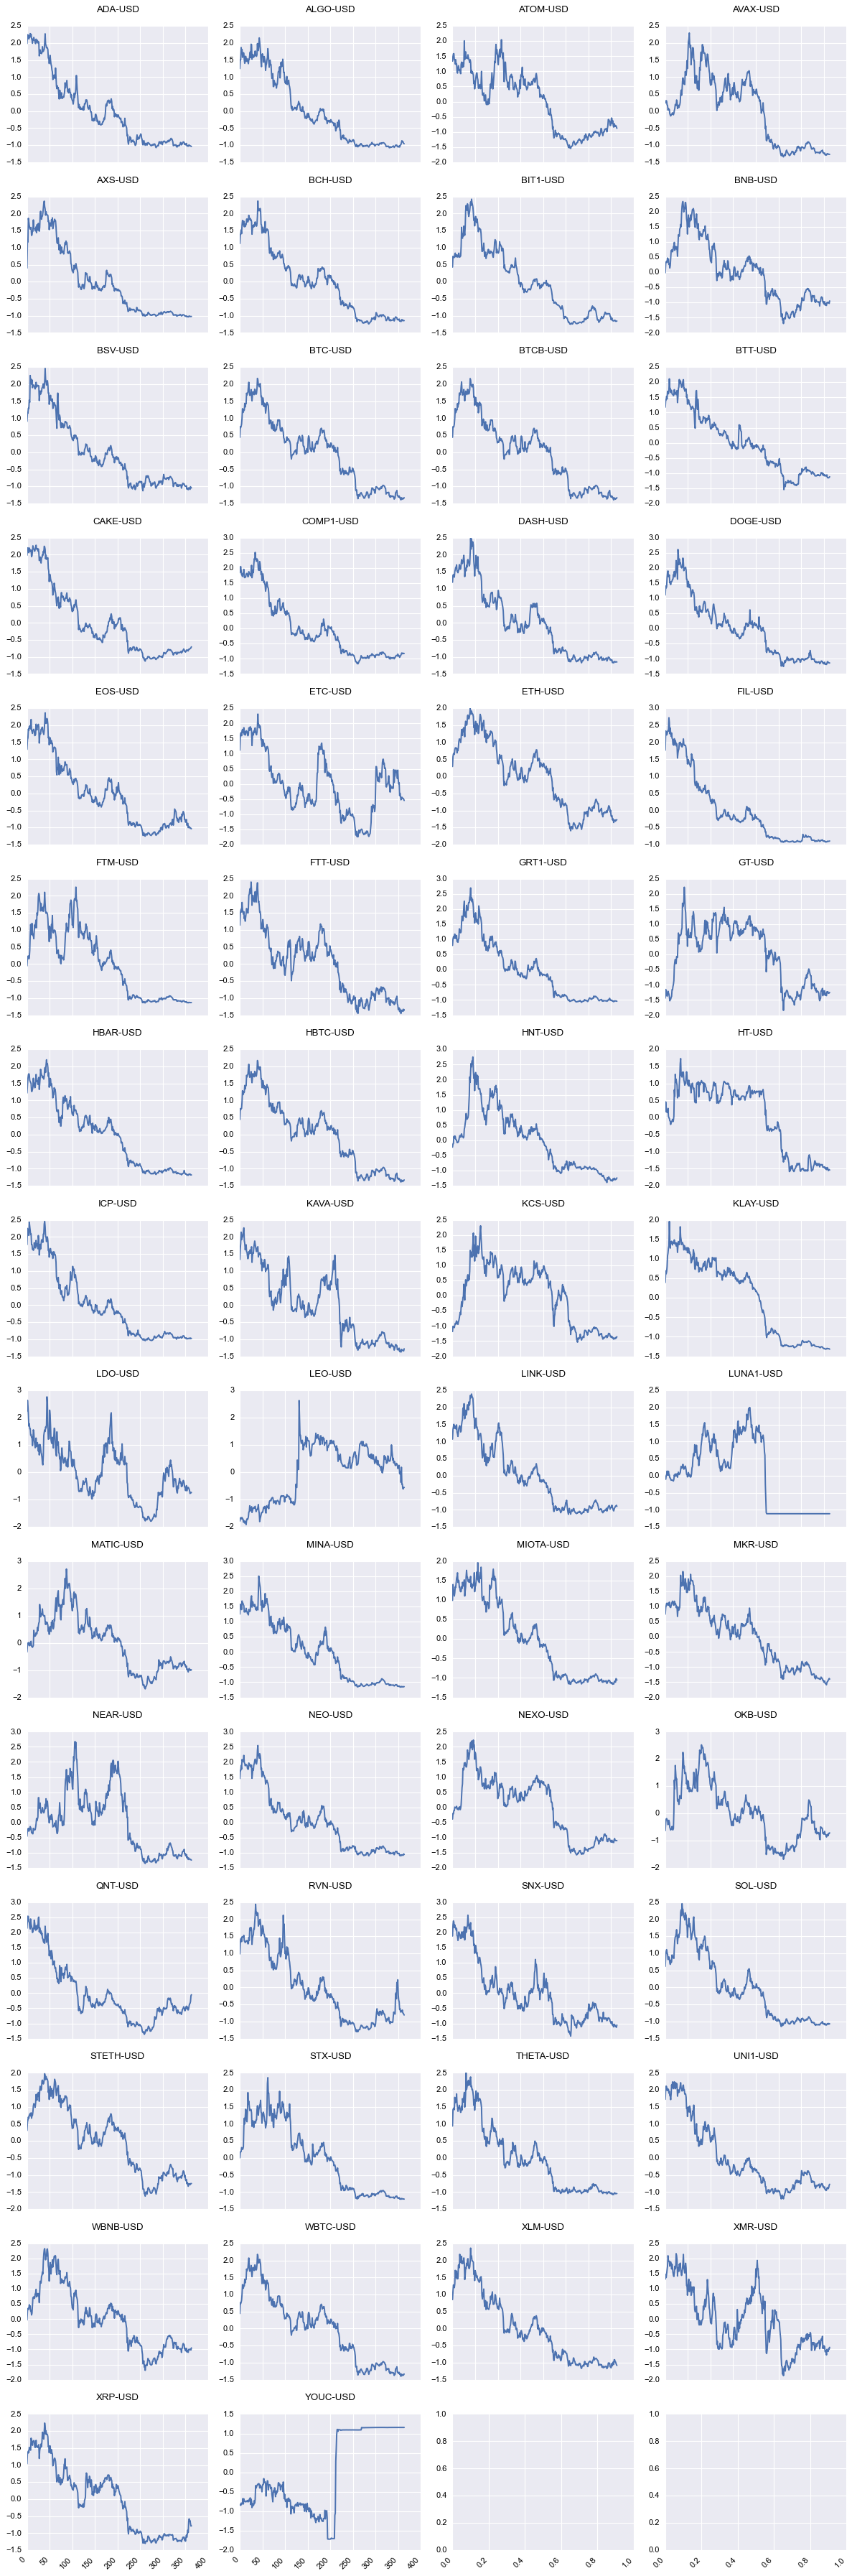

=======================================================  Cluster 1  =================================================================================================


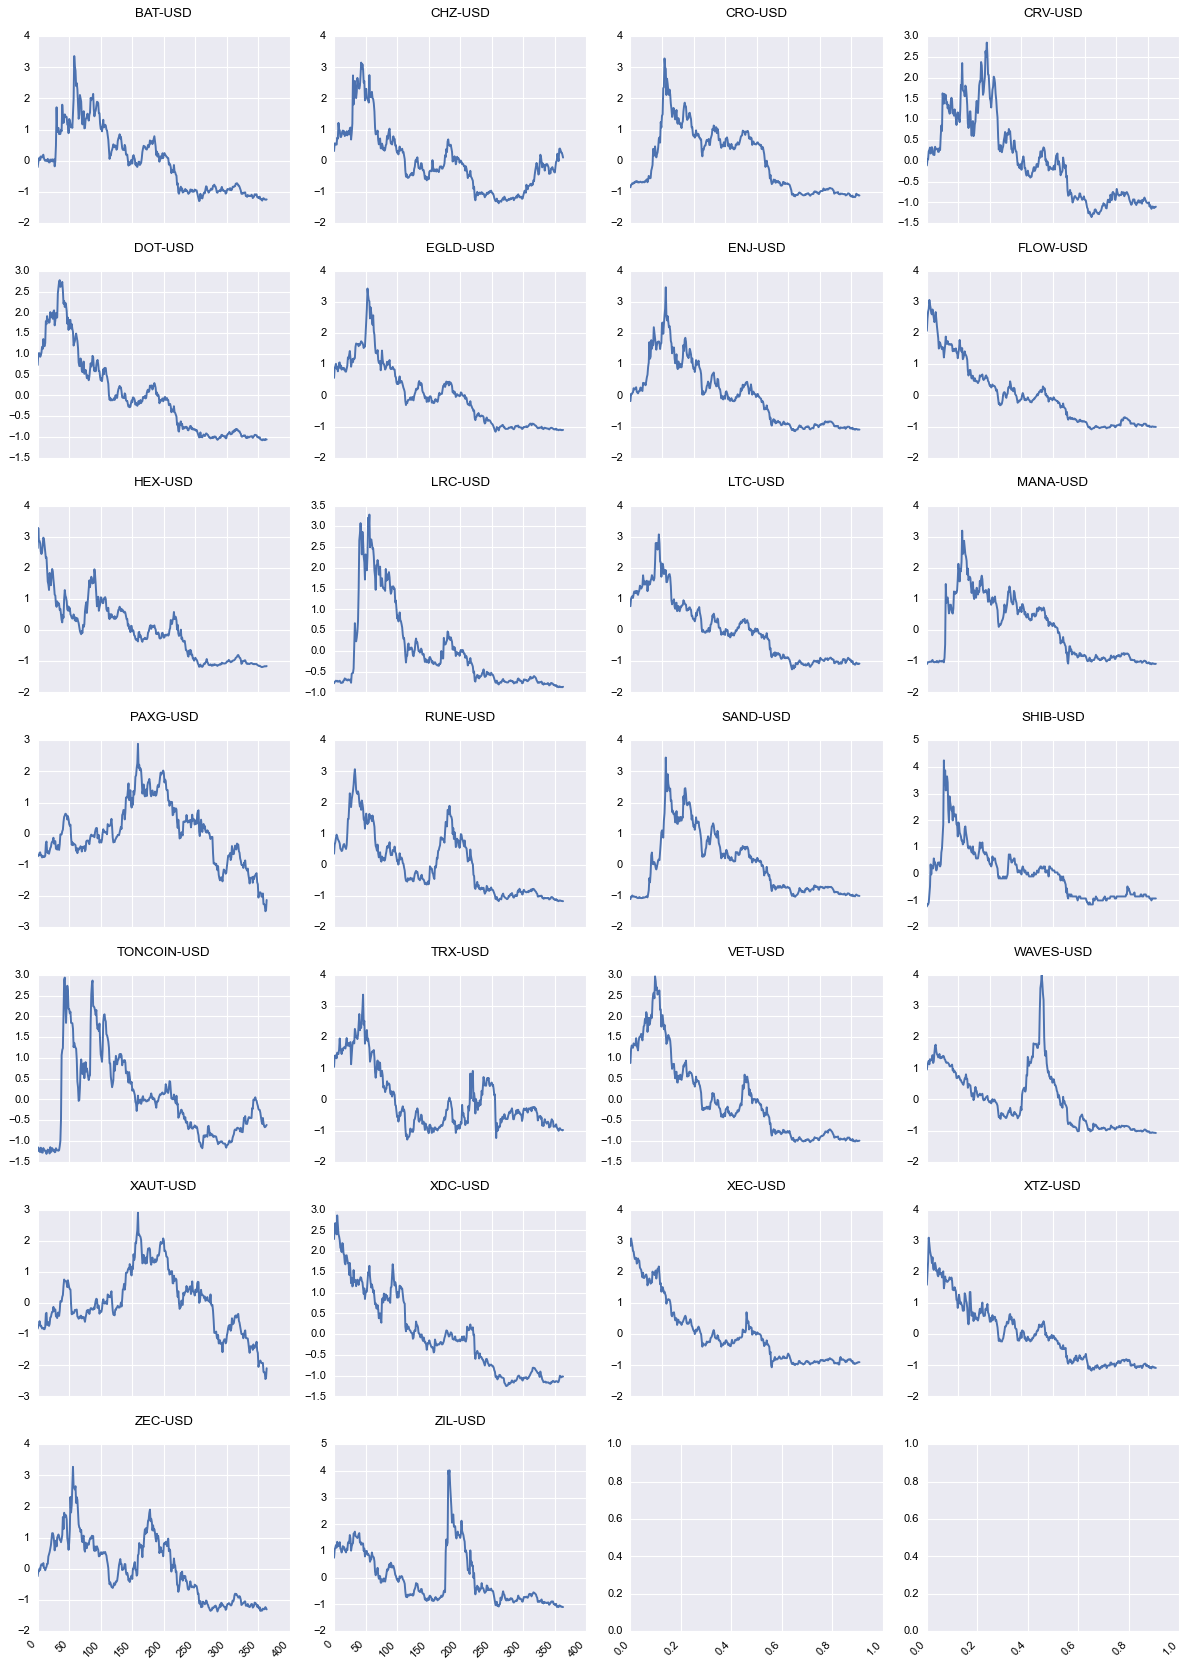

=======================================================  Cluster 2  =================================================================================================


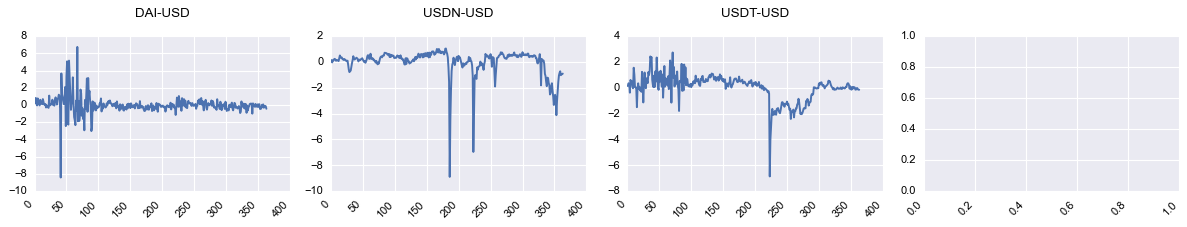

=======================================================  Cluster 3  =================================================================================================


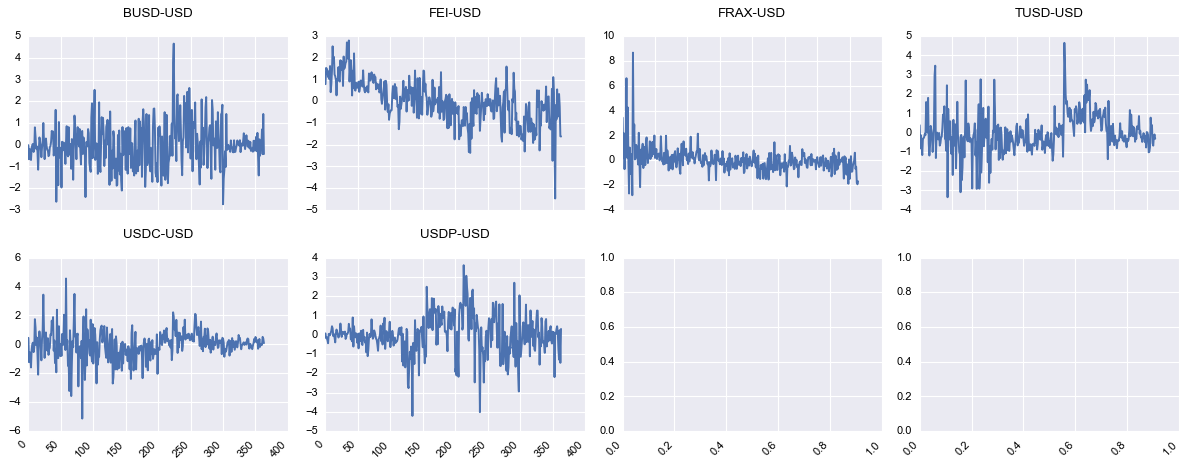

In [295]:
df_cluster = data_scaled_df.copy()
df_cluster['ticker']=df_cluster.index
for cluster in range(0, 4):
    print(f"=======================================================  Cluster {cluster}  =================================================================================================")
    plot_cluster_tickers(df_cluster.loc[df_cluster.index[kmeans_time_features.labels_ == cluster]])

##### Визуально можем отметить, что элементы time-features кластера очень похожи друг на друга, но при том не учитывают статистические особенности рядов.
У comperhensive features ниже показатель ошибки, что делает прогноз по этим фичам более качественным.
В целом feature-extractor'ы могут быть полезны так как после их применения, в нашем случае, SSE уменьишлось. Следовательно кластеризация стала работать лучше.